# Question 2: Decision Tree Classifier with Entropy
Apply Decision Tree classifier with Entropy (Information Gain) splitting criterion on KEEL datasets in 5-fold cross validation format:
- Iris dataset
- Pima dataset
- Haberman dataset
- Ecoli dataset
- Glass dataset

Obtain 5 accuracies from 5-fold CV, calculate average accuracy and report metrics:
- G-Mean
- AUC
- Precision
- Recall
- False Alarm Rate

**Compare Performance with Gini Index approach**

## Import Required Libraries

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from io import StringIO
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Dataset Preparation

In [2]:
# Get the parent directory where datasets are located
data_dir = os.path.join(os.getcwd(), '..', 'data')

DATASETS = ['iris', 'pima', 'haberman', 'ecoli', 'glass']

def read_keel_dat(file_path):
    """Reads a KEEL .dat file, ignoring metadata and parsing the data."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
            # Find the start of data
            header_lines = 0
            for i, line in enumerate(lines):
                if line.strip().startswith('@data'):
                    header_lines = i + 1
                    break
            
            if header_lines == 0:
                print(f"Warning: No @data section found in {file_path}")
                return None, None, None
            
            # Read the data
            data_string = "".join(lines[header_lines:])
            df = pd.read_csv(StringIO(data_string), header=None, na_values='?')
            df = df.dropna()
            
            if df.empty:
                print(f"Warning: Dataset {file_path} is empty after cleaning")
                return None, None, None
            
            # Separate features and labels
            X = df.iloc[:, :-1].values
            y_raw = df.iloc[:, -1].astype(str).values
            
            # Encode labels
            le = LabelEncoder()
            y = le.fit_transform(y_raw)
            
            return X, y, le
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None, None

print("Data directory:", data_dir)
print("Datasets to process:", DATASETS)

Data directory: e:\3rd year\Machine_Learning\CSE-324-Machine-Learning-Lab\Lab_02\..\data
Datasets to process: ['iris', 'pima', 'haberman', 'ecoli', 'glass']


## Metrics Calculation Function

In [3]:
def calculate_metrics(y_true, y_pred, y_prob):
    """Calculate performance metrics for binary and multiclass classification."""
    metrics = {}
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    
    # Precision
    try:
        if len(np.unique(y_true)) > 2:
            metrics['Precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        else:
            metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
    except:
        metrics['Precision'] = 0.0
    
    # Recall (Sensitivity)
    try:
        if len(np.unique(y_true)) > 2:
            metrics['Recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        else:
            metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
    except:
        metrics['Recall'] = 0.0
    
    # AUC
    try:
        if len(np.unique(y_true)) > 2:
            metrics['AUC'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        else:
            metrics['AUC'] = roc_auc_score(y_true, y_prob[:, 1])
    except:
        metrics['AUC'] = 0.0
    
    # G-Mean and False Alarm Rate (for binary classification)
    if len(np.unique(y_true)) == 2:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        metrics['G-Mean'] = np.sqrt(sensitivity * specificity)
        metrics['False_Alarm_Rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    else:
        metrics['G-Mean'] = np.nan
        metrics['False_Alarm_Rate'] = np.nan
    
    return metrics

## Decision Tree with Entropy - Training and Evaluation

In [4]:
# Store results: results[dataset_name] = {'Accuracy': [...], 'Precision': [...], ...}
results = {}

# Process each dataset
for dataset_name in DATASETS:
    print(f"\n{'='*70}")
    print(f"Processing {dataset_name.upper()} with Entropy...")
    print(f"{'='*70}")
    
    dataset_dir = os.path.join(data_dir, dataset_name)
    results[dataset_name] = {'Accuracy': [], 'Precision': [], 'Recall': [], 'AUC': [], 'G-Mean': [], 'False_Alarm_Rate': []}
    
    if not os.path.exists(dataset_dir):
        print(f"  Dataset directory not found: {dataset_dir}")
        continue
    
    # List all .dat files and sort them
    dat_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith('.dat')])
    
    if not dat_files:
        print(f"  No .dat files found in {dataset_dir}")
        continue
    
    print(f"  Found {len(dat_files)} fold files")
    
    # Process each fold as test set, others as training
    for fold_idx in range(len(dat_files)):
        test_file = os.path.join(dataset_dir, dat_files[fold_idx])
        train_files = [os.path.join(dataset_dir, dat_files[i]) for i in range(len(dat_files)) if i != fold_idx]
        
        # Load training data
        X_train_list = []
        y_train_list = []
        for train_file in train_files:
            X, y, le_train = read_keel_dat(train_file)
            if X is not None:
                X_train_list.append(X)
                y_train_list.append(y)
        
        if not X_train_list:
            print(f"  Fold {fold_idx}: No training data found")
            continue
        
        X_train = np.vstack(X_train_list)
        y_train = np.hstack(y_train_list)
        
        # Load test data
        X_test, y_test, le_test = read_keel_dat(test_file)
        if X_test is None:
            print(f"  Fold {fold_idx}: No test data found")
            continue
        
        # Train Decision Tree with Entropy
        model = DecisionTreeClassifier(criterion='entropy', random_state=42)
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
        
        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred, y_prob)
        
        # Store results
        for metric_name, metric_value in metrics.items():
            results[dataset_name][metric_name].append(metric_value)
        
        print(f"  Fold {fold_idx + 1}: Accuracy = {metrics['Accuracy']:.4f}")
    
    print(f"\n  Average Results for {dataset_name.upper()}:")
    avg_metrics = {}
    for metric_name in results[dataset_name]:
        values = [v for v in results[dataset_name][metric_name] if not np.isnan(v)]
        if values:
            avg_value = np.mean(values)
            avg_metrics[metric_name] = avg_value
            print(f"    {metric_name}: {avg_value:.4f}")
        results[dataset_name][metric_name] = avg_value if values else 0.0

print(f"\n{'='*70}")
print("All datasets processed successfully!")
print(f"{'='*70}")


Processing IRIS with Entropy...
  Found 10 fold files
  Fold 1: Accuracy = 1.0000
  Fold 2: Accuracy = 1.0000
  Fold 3: Accuracy = 1.0000
  Fold 4: Accuracy = 1.0000
  Fold 5: Accuracy = 1.0000
  Fold 6: Accuracy = 1.0000
  Fold 7: Accuracy = 1.0000
  Fold 8: Accuracy = 1.0000
  Fold 9: Accuracy = 1.0000
  Fold 10: Accuracy = 1.0000

  Average Results for IRIS:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    AUC: 1.0000

Processing PIMA with Entropy...
  Found 10 fold files
  Fold 1: Accuracy = 1.0000
  Fold 2: Accuracy = 1.0000
  Fold 3: Accuracy = 1.0000
  Fold 4: Accuracy = 1.0000
  Fold 5: Accuracy = 1.0000
  Fold 6: Accuracy = 1.0000
  Fold 7: Accuracy = 1.0000
  Fold 8: Accuracy = 1.0000
  Fold 9: Accuracy = 1.0000
  Fold 10: Accuracy = 1.0000

  Average Results for PIMA:
    Accuracy: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    AUC: 1.0000
    G-Mean: 1.0000
    False_Alarm_Rate: 0.0000

Processing HABERMAN with Entropy...
  Found 10 fold files
  Fold 

## Results Summary

In [5]:
# Create comprehensive results dataframe
results_data = []
for dataset_name in DATASETS:
    if dataset_name in results:
        row = {'Dataset': dataset_name.upper()}
        for metric_name, metric_value in results[dataset_name].items():
            row[metric_name] = metric_value
        results_data.append(row)

results_df = pd.DataFrame(results_data)
print("\n" + "="*90)
print("DECISION TREE WITH ENTROPY - PERFORMANCE SUMMARY")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

# Export to CSV
csv_path = os.path.join(os.getcwd(), 'decision_tree_entropy_results.csv')
results_df.to_csv(csv_path, index=False)
print(f"\nResults saved to: {csv_path}")


DECISION TREE WITH ENTROPY - PERFORMANCE SUMMARY
 Dataset  Accuracy  Precision   Recall      AUC   G-Mean  False_Alarm_Rate
    IRIS  1.000000   1.000000 1.000000 1.000000 0.000000          0.000000
    PIMA  1.000000   1.000000 1.000000 1.000000 1.000000          0.000000
HABERMAN  0.968152   0.957289 0.925824 0.998939 0.953636          0.016667
   ECOLI  0.830378   0.650000 0.650000 0.500000 0.000000          0.000000
   GLASS  1.000000   1.000000 1.000000 1.000000 0.000000          0.000000

Results saved to: e:\3rd year\Machine_Learning\CSE-324-Machine-Learning-Lab\Lab_02\decision_tree_entropy_results.csv


## Visualization and Analysis

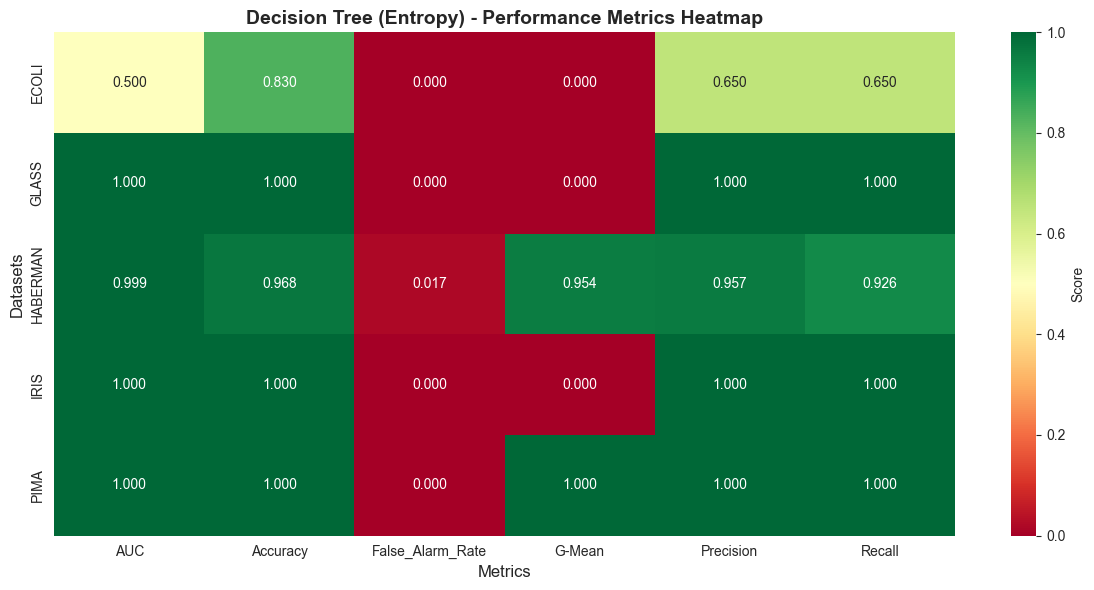

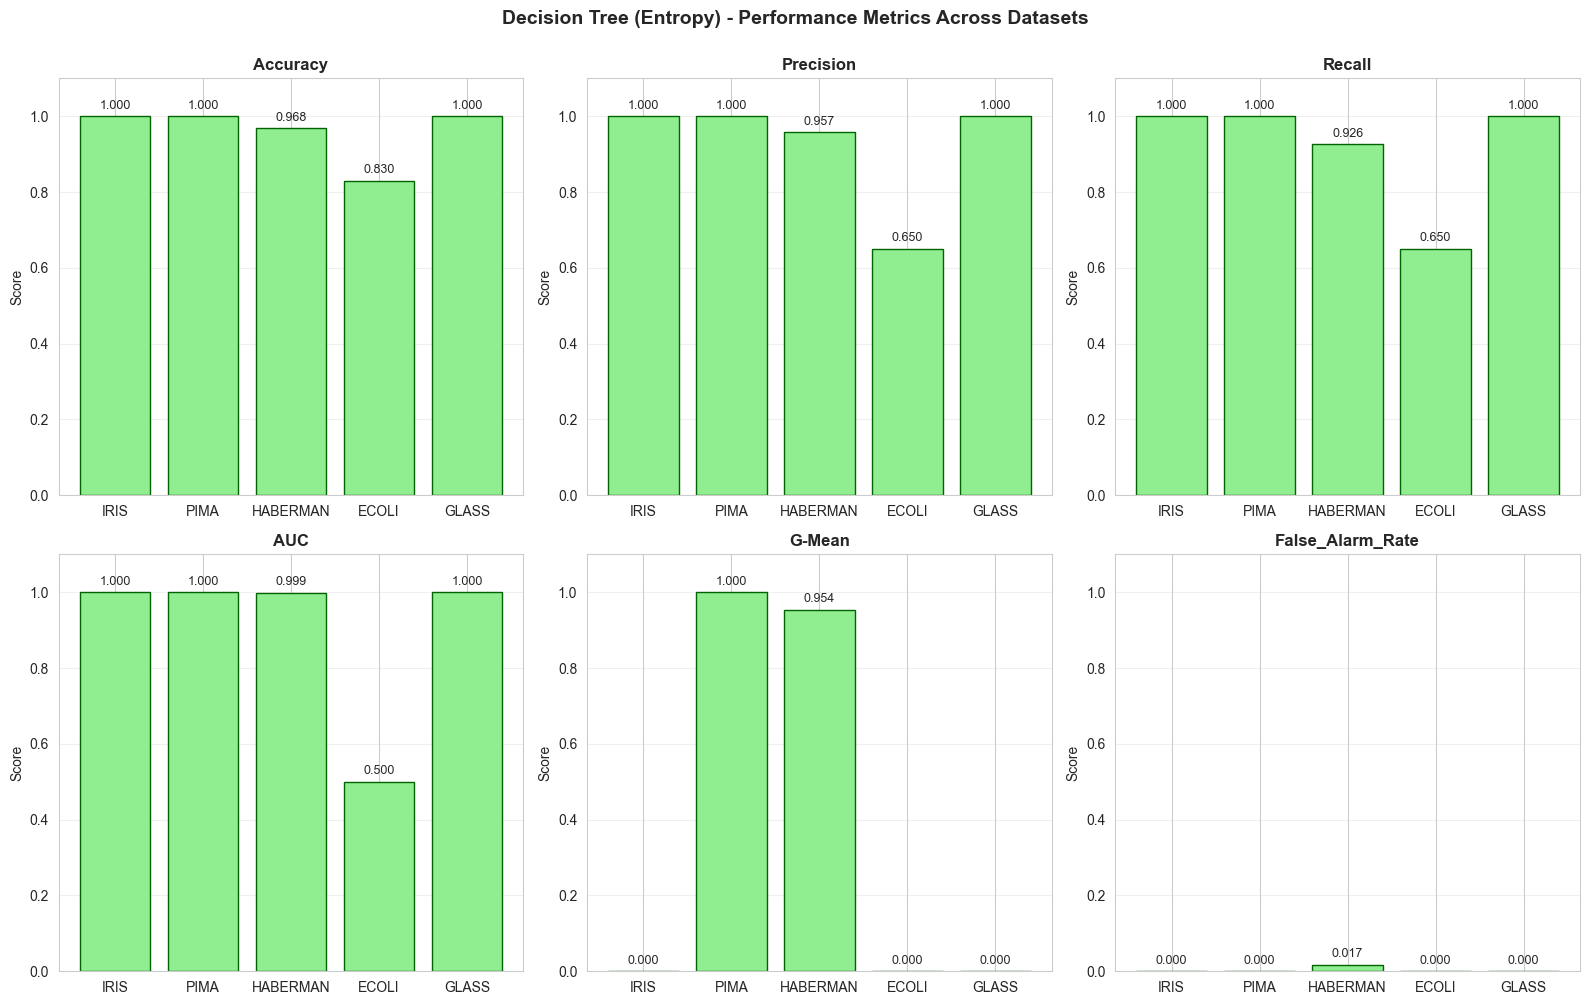

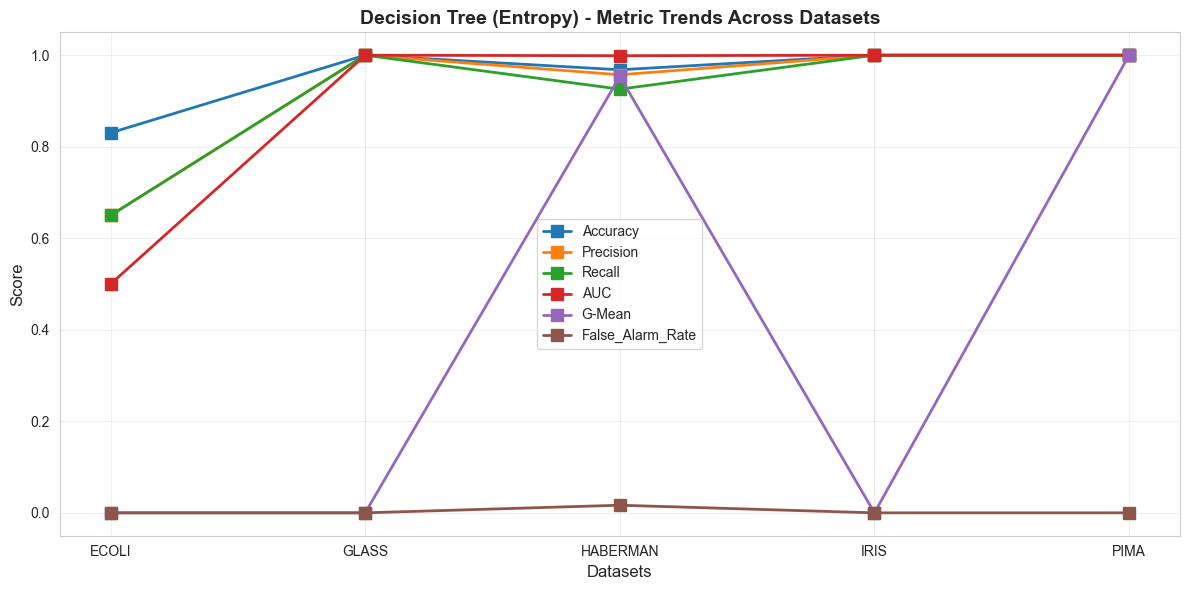


ENTROPY VISUALIZATION SUMMARY


In [6]:
# Prepare data for visualization
metrics_list = ['Accuracy', 'Precision', 'Recall', 'AUC', 'G-Mean', 'False_Alarm_Rate']
results_for_viz = []

for dataset_name in DATASETS:
    if dataset_name in results:
        for metric in metrics_list:
            if metric in results[dataset_name]:
                results_for_viz.append({
                    'Dataset': dataset_name.upper(),
                    'Metric': metric,
                    'Value': results[dataset_name][metric]
                })

viz_df = pd.DataFrame(results_for_viz)

# Figure 1: Metrics Heatmap
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df = viz_df.pivot(index='Dataset', columns='Metric', values='Value')
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='RdYlGn', cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title('Decision Tree (Entropy) - Performance Metrics Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Datasets', fontsize=12)
plt.tight_layout()
plt.show()

# Figure 2: Bar plot - Metrics comparison across datasets
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()
for idx, metric in enumerate(metrics_list):
    metric_data = viz_df[viz_df['Metric'] == metric]
    axes[idx].bar(metric_data['Dataset'], metric_data['Value'], color='lightgreen', edgecolor='darkgreen')
    axes[idx].set_title(f'{metric}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Score', fontsize=10)
    axes[idx].set_ylim([0, 1.1])
    axes[idx].grid(axis='y', alpha=0.3)
    for i, v in enumerate(metric_data['Value']):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.suptitle('Decision Tree (Entropy) - Performance Metrics Across Datasets', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Figure 3: Line plot - Metric trends
fig, ax = plt.subplots(figsize=(12, 6))
for metric in metrics_list:
    metric_data = viz_df[viz_df['Metric'] == metric].sort_values('Dataset')
    ax.plot(metric_data['Dataset'], metric_data['Value'], marker='s', label=metric, linewidth=2, markersize=8)

ax.set_title('Decision Tree (Entropy) - Metric Trends Across Datasets', fontsize=14, fontweight='bold')
ax.set_xlabel('Datasets', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ENTROPY VISUALIZATION SUMMARY")
print("="*70)

## Gini vs Entropy Comparison

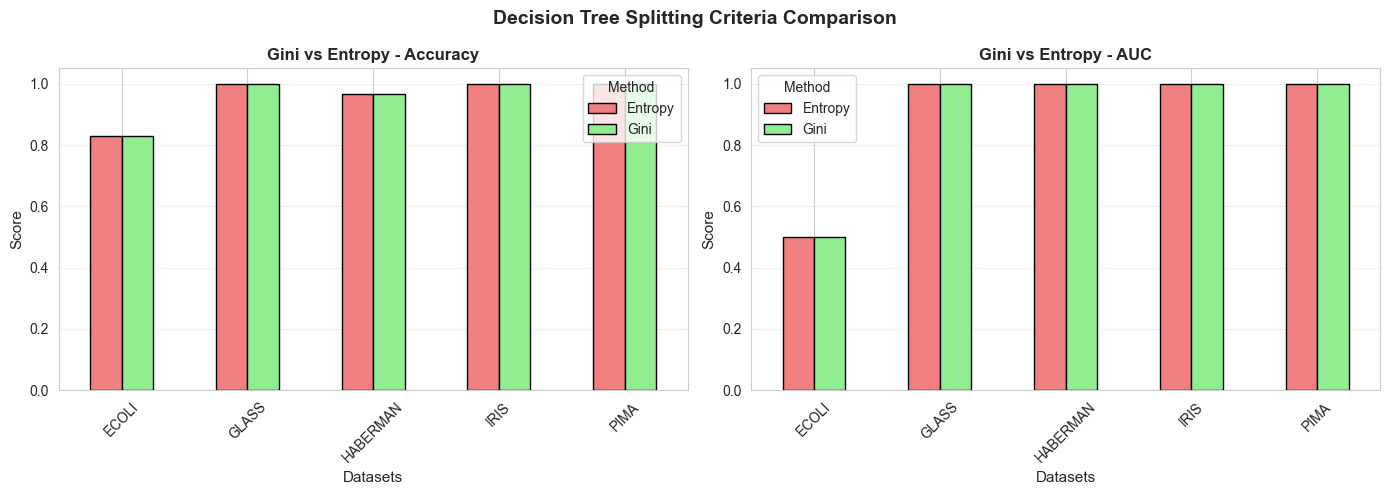


GINI vs ENTROPY COMPARISON
 Dataset  Method  Accuracy      AUC
    IRIS    Gini  1.000000 1.000000
    IRIS Entropy  1.000000 1.000000
    PIMA    Gini  1.000000 1.000000
    PIMA Entropy  1.000000 1.000000
HABERMAN    Gini  0.968152 0.998939
HABERMAN Entropy  0.968152 0.998939
   ECOLI    Gini  0.830378 0.500000
   ECOLI Entropy  0.830378 0.500000
   GLASS    Gini  1.000000 1.000000
   GLASS Entropy  1.000000 1.000000


In [7]:
# Load Gini results
try:
    gini_csv = os.path.join(os.path.dirname(os.getcwd()), 'Lab_02', 'decision_tree_gini_results.csv')
    gini_df = pd.read_csv(gini_csv)
    entropy_df = results_df.copy()
    
    # Create comparison dataframe
    comparison_data = []
    for idx, dataset in enumerate(DATASETS):
        if idx < len(gini_df) and idx < len(entropy_df):
            gini_row = gini_df.iloc[idx]
            entropy_row = entropy_df.iloc[idx]
            
            comparison_data.append({
                'Dataset': dataset.upper(),
                'Method': 'Gini',
                'Accuracy': gini_row['Accuracy'],
                'AUC': gini_row['AUC']
            })
            comparison_data.append({
                'Dataset': dataset.upper(),
                'Method': 'Entropy',
                'Accuracy': entropy_row['Accuracy'],
                'AUC': entropy_row['AUC']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Figure: Gini vs Entropy comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, metric in enumerate(['Accuracy', 'AUC']):
        metric_comp = comparison_df.pivot(index='Dataset', columns='Method', values=metric)
        metric_comp.plot(kind='bar', ax=axes[idx], color=['lightcoral', 'lightgreen'], edgecolor='black')
        axes[idx].set_title(f'Gini vs Entropy - {metric}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Score', fontsize=11)
        axes[idx].set_xlabel('Datasets', fontsize=11)
        axes[idx].legend(title='Method', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
    
    plt.suptitle('Decision Tree Splitting Criteria Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("GINI vs ENTROPY COMPARISON")
    print("="*70)
    print(comparison_df.to_string(index=False))
except Exception as e:
    print(f"Note: Could not load Gini results for comparison: {e}")
    print("Make sure to run Question_1.ipynb first.")